# Gerchberg-Saxton (GS) Algorithm for Holocurtain

### [Link to the paper](https://imaging.cs.cmu.edu/holocurtains/#home)

![GS algorithm in holocurtain paper](imgs/GS_paper.jpg)

In [2]:
import numpy as np
import numpy.fft as F
import matplotlib.pyplot as plt
import PIL.Image as Image
import requests

In [3]:
# step1: Random Init for 2D binary image
def random_init(w: int, h: int) -> np.ndarray:
    return np.random.randint(0, 2, (w, h))

# plt.imshow(random_init(10, 10), cmap='gray')

In [4]:
def img_normalize(img: np.ndarray) -> np.ndarray:
    return (img - img.min()) / (img.max() - img.min())

In [5]:
def GS(target: np.ndarray, iter: int = 10, abr: np.ndarray = None) -> np.ndarray:
    h, w = target.shape
    # step1: Random Init for 2D binary image
    u = np.random.rand(h, w) >= 0.5
    u = u.astype(np.complex_)
    if abr is None:
        abr = np.ones_like(target)
    for _ in range(iter):
        # step2: Forward Propagation
        u = F.fft2(u * abr)
        u = F.fftshift(u)
        # step3: Amplitude Constraint
        u = np.sqrt(target) * np.exp(1j * np.angle(u))
        # step4: Backward Propagation
        u = F.ifftshift(u)
        u = F.ifft2(u)
        # step5: Binary Constraint
        u = np.real(u) >= 0
        u = u.astype(np.complex_)

    return u

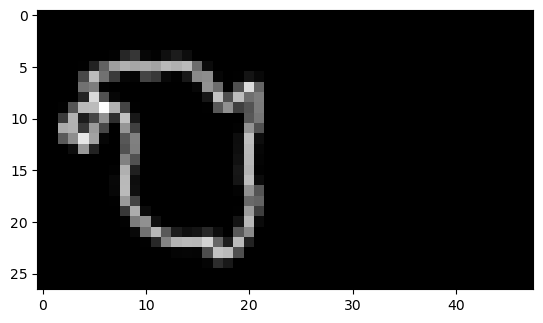

In [6]:
try:
    img = np.array(Image.open('imgs/target_pixelized.bmp'))
except FileNotFoundError:
    img = np.array(Image.open(requests.get('https://raw.githubusercontent.com/zhuyuezx/CSC494_holoprojector/main/Code/imgs/target_pixelized.bmp', stream=True).raw))
img = img / 255.
plt.imshow(img, cmap='gray')

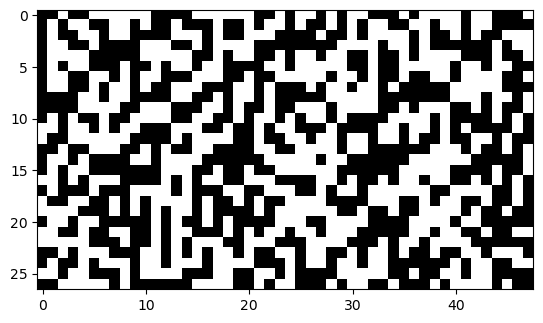

In [7]:
# Basic setting where there's no abrration
ret = GS(img, 1000)
# see the final result for step 5
plt.imshow(ret.real, cmap='gray')

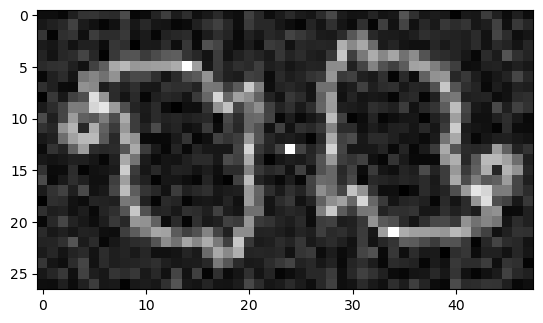

In [8]:
# See the final result for step 3
to_plot = np.fft.fft2(ret)
to_plot[0, 0] = 0
to_plot = img_normalize(np.abs(to_plot))
to_plot[0, 0] = to_plot.max()
to_plot = np.fft.fftshift(to_plot)
plt.imshow(np.abs(to_plot), cmap='gray')

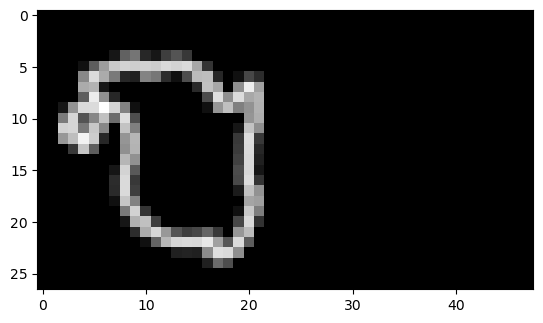

In [9]:
# See the final result for step 4
to_plot2 = np.fft.fft2(ret)
to_plot2 = np.sqrt(img) * np.exp(1j * np.angle(to_plot2))
plt.imshow(np.abs(to_plot2), cmap='gray')